In [1]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas
from collections import Counter

In [2]:
TRAIN_DIR = 'C:/Users/Asus/Downloads/animals/animals'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['cats', 'dogs', 'panda']


In [3]:
TRAIN_DATA = []
IMG_SIZE = 32
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path,img))
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
        img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 1000/1000 [00:13<00:00, 73.53it/s]

3000


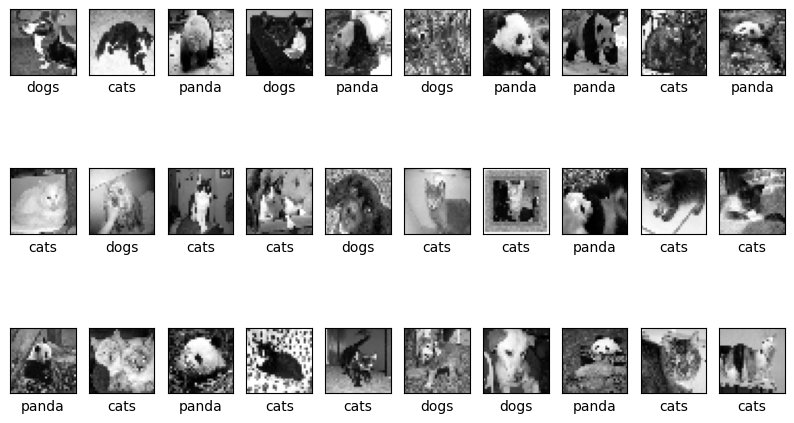

In [4]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,10,i+1)
    image = TRAIN_DATA[i][0]
    plt.imshow(image, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [5]:
f0 = TRAIN_DATA[0:600]
f1 = TRAIN_DATA[600:1200]
f2 = TRAIN_DATA[1200:1800]
f3 = TRAIN_DATA[1800:2400]
f4 = TRAIN_DATA[2400:3000]

In [6]:
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

In [7]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

In [8]:
top_filter = 20

def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []

    for valid in tqdm(valid_fold):
        temp_dist_list = []

        for train in train_fold:
            l1_distance = l1_dist(valid[0], train[0])
            l2_distance = l2_dist(valid[0], train[0])
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_distance, "l2": l2_distance}])

        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])

    return [l1_result, l2_result]

In [9]:
k_range = 20

def cal_accuracy(dist_result, dist_term):
    k_accuracies = []

    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)

            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1

            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # in case of a tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist < diff_class_dist:
                        img_accuracy += 1

        k_accuracies.append(img_accuracy/len(dist_result))

    return k_accuracies

In [10]:
dist_by_fold = []
import math
for i in range(5):
    if i==0:
        train = f1+f2+f3+f4
        validation = f0
    elif i==1:
        train = f0+f2+f3+f4
        validation = f1
    elif i==2:
        train = f1+f0+f3+f4
        validation = f2
    elif i==3:
        train = f1+f2+f0+f4
        validation = f3
    elif i==4:
        train = f1+f2+f3+f0
        validation = f4

    dist_by_fold.append(distance_calc(train, validation))

100%|██████████| 600/600 [01:33<00:00,  6.42it/s]


In [11]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])
    
len(accuracies)

5

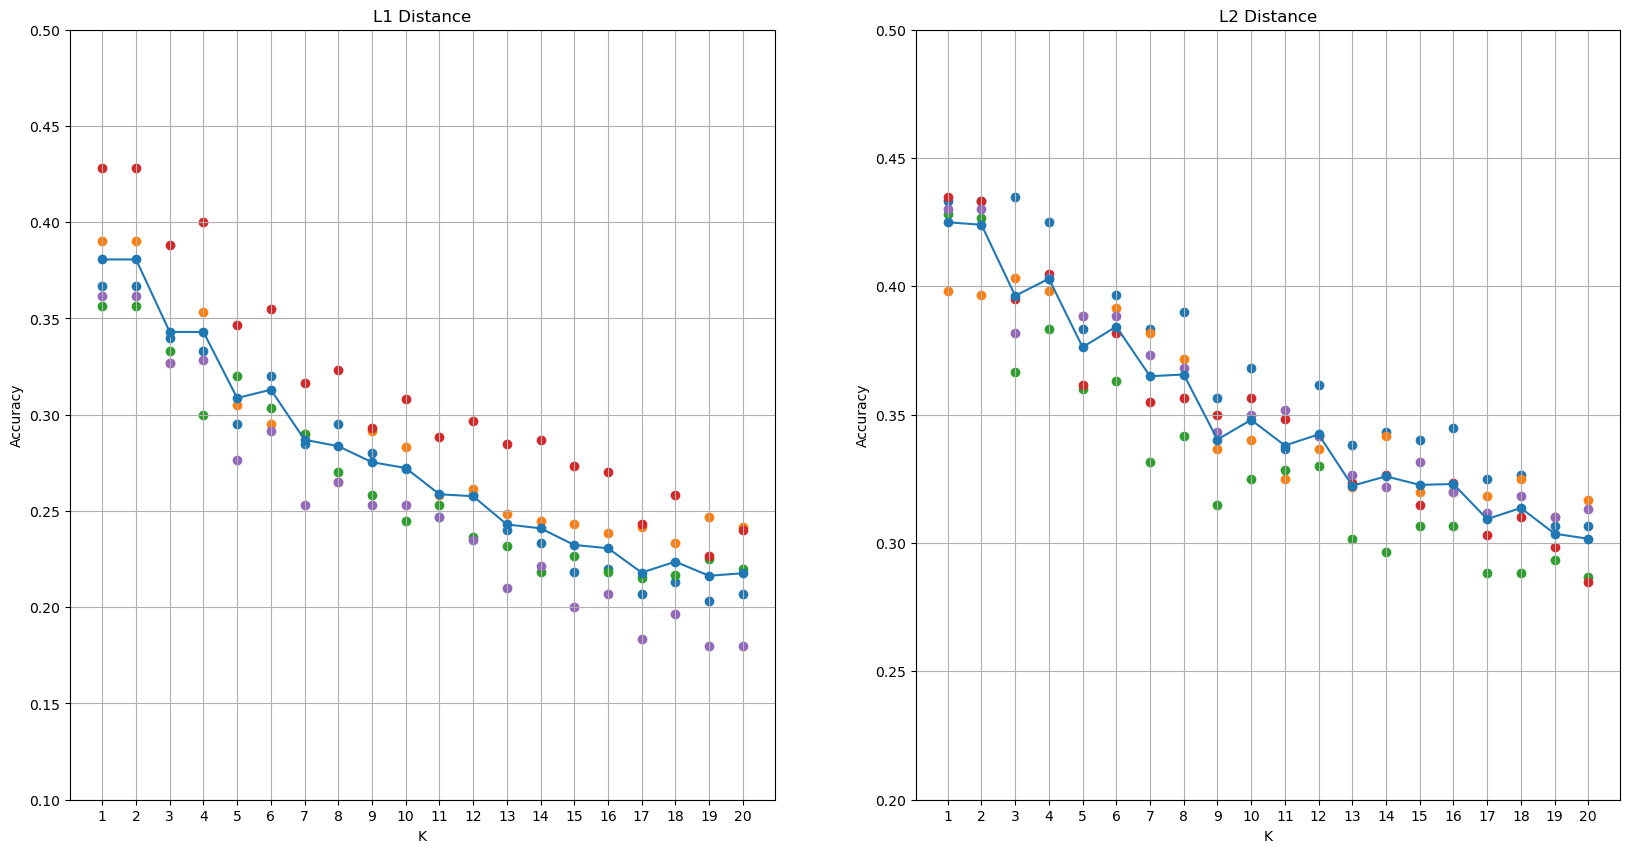

In [12]:
# l1 distance accuracy plot

x_list = list(range(1, k_range+1))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.1, 0.5)

# l2 distance accuracy plot
x_list = list(range(1, k_range+1))

plt.subplot(1,2,2)
for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.5)
plt.show()

# Discussion:

From the graphs it can be seen that, both distance(L1 and L2) metrics exihit a general trend of decreasing mean accuracy as the the k increases. Initially, the L2 distance shows a slightly higher for smaller values of k compared to L1 distance.However, both metrics converge towards lower accuracy, but in the case of L1, it converges to a lower accuracy than L2. .The L2 distance demonstrates highest accuracy at points,such as k = 1(42% approximately). And for L1, the highest accuracy is approximately 38% when k = 1 and k = 2. Since the dataset consists of grayscale images, the features are likely pixel intensities. The nature of these features can significantly influence the effectiveness of the distance metric used. Specifically, the robustness of the L1 distance to outliers may be advantageous in situations where noise or artifacts are present in the images. On the other hand, the L2 distance, being more sensitive to the magnitude of differences due to its squaring operation, might better capture the subtle variations in pixel intensities that distinguish different classes.

Overall, both Manhattan (L1) and Euclidean (L2) distances display similar patterns of performance degradation with increasing k values. Nevertheless, L2 occasionally outperforms L1 at certain lower values of k, highlighting its potential advantage in specific contexts within the dataset.

For L2 distance, the absence of feature scaling can significantly impact performance, as this metric is sensitive to the scale of features. Applying standardization or normalization to the pixel intensities in grayscale images could improve accuracy. While other distance metrics might offer more robust results in certain scenarios, ensuring that features are on a consistent scale is crucial for models relying on L2 distance.

Additionally, for a small grayscale image dataset (e.g., 3,000 images), data augmentation techniques can be used to expand the dataset and enhance the model's learning capability, thereby improving accuracy. Data augmentation can introduce variations such as rotation, scaling, or flipping, which helps the model generalize better to new, unseen data.

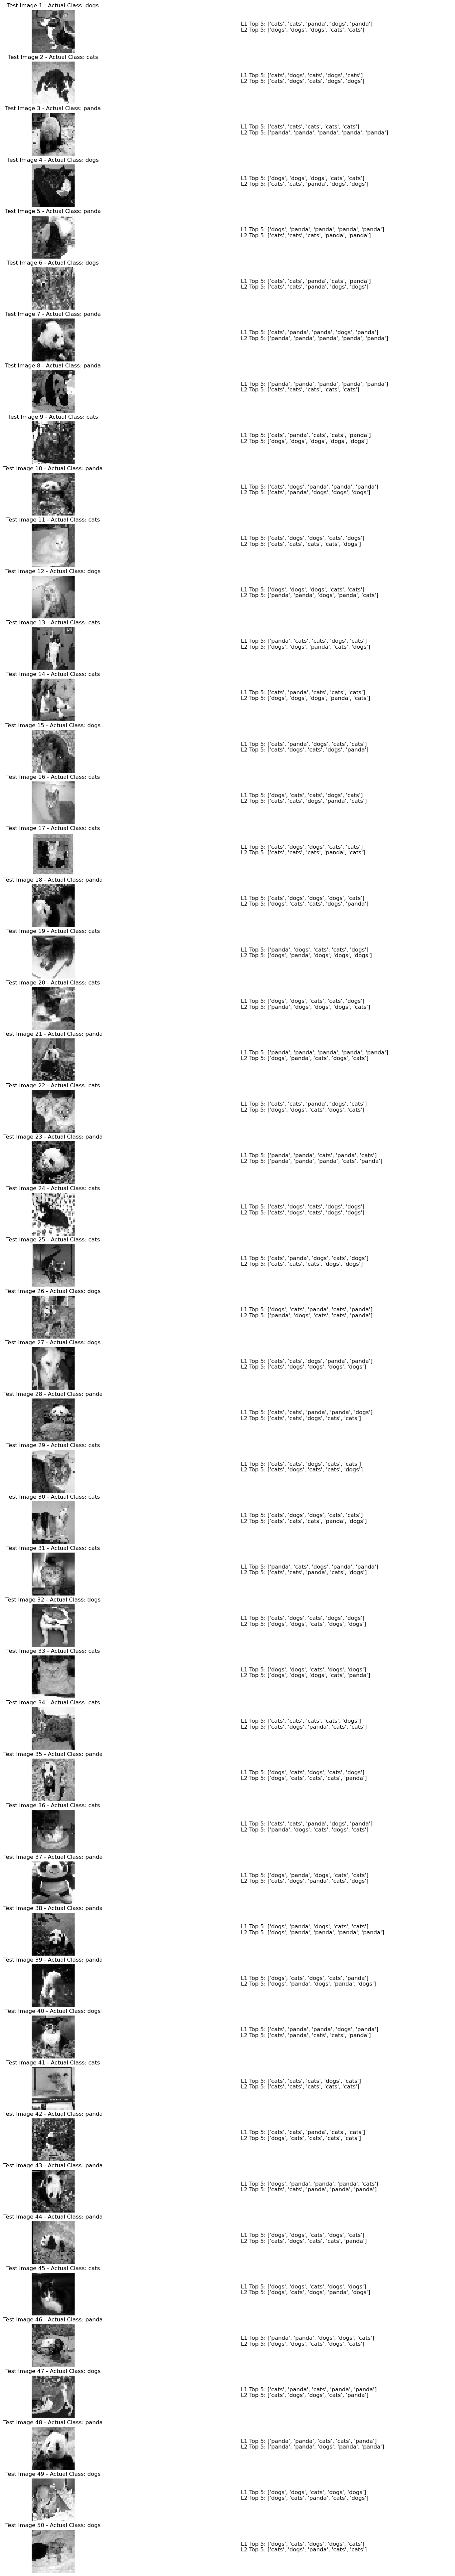

In [13]:
TEST_DATA = TRAIN_DATA[:50]  
TRAIN_DATA = TRAIN_DATA[50:]  

top_k = 5
top_predictions = []

for test_img, test_class in TEST_DATA:
    distances = []
    
    for train_img, train_class in TRAIN_DATA:
        l1_distance = l1_dist(test_img, train_img)
        l2_distance = l2_dist(test_img, train_img)
        distances.append([train_class, {"l1": l1_distance, "l2": l2_distance}])
    
   
    distances.sort(key=lambda x: x[1]["l1"])
    top_k_predictions_l1 = distances[:top_k]
    
   
    distances.sort(key=lambda x: x[1]["l2"])
    top_k_predictions_l2 = distances[:top_k]
    
    top_predictions.append([top_k_predictions_l1, top_k_predictions_l2])


plt.figure(figsize=(20, len(TEST_DATA) * 2))

for i, (test_img, test_class) in enumerate(TEST_DATA):
    plt.subplot(len(TEST_DATA), 2, 2*i+1)
    plt.imshow(test_img, cmap="gray")
    plt.title(f"Test Image {i+1} - Actual Class: {CATEGORIES[test_class]}")
    plt.axis('off')
    
    plt.subplot(len(TEST_DATA), 2, 2*i+2)
    top_l1 = [CATEGORIES[pred[0]] for pred in top_predictions[i][0]]
    top_l2 = [CATEGORIES[pred[0]] for pred in top_predictions[i][1]]
    plt.text(0.1, 0.5, f"L1 Top 5: {top_l1}\nL2 Top 5: {top_l2}", fontsize=12)
    plt.axis('off')

plt.show()
